chapter 11 - Training Dep Neural Networks

# Setup

In [17]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [20]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

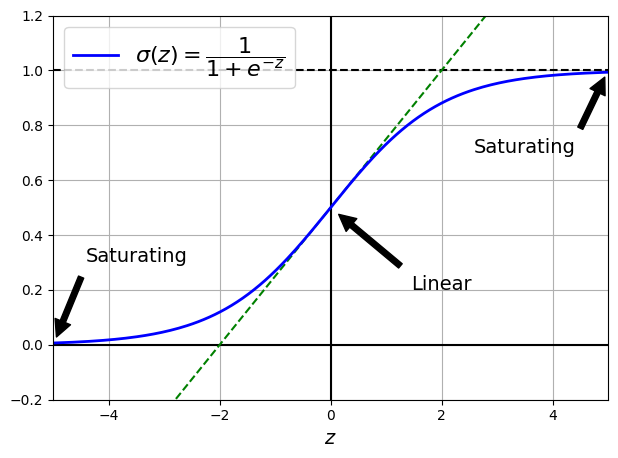

In [21]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

네트워크에서 기울기 vanishing/exploding 문제를 해결하기 위한 He Initialize 방법

In [22]:
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

He 초기화 (ReLU용)
- ReLU 계열 활성화 함수를 쓸 때 전파 시 각 층의 출력 분산을 일정하게 유지하도록 설계된 방식 
    - 학습 초기에 신호와 그레디언트 분산이 안정되어 학습이 잘 진행됨
- 50개 뉴런, ReLU 활성화

In [23]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

He 초기화(Sigmoid용)
- norm이 아닌 he_avg_init으로 초기화
    - variance scale=2, fan_avg, uniform distribution

## Nonsaturating Activation Functions
### Leaky ReLU

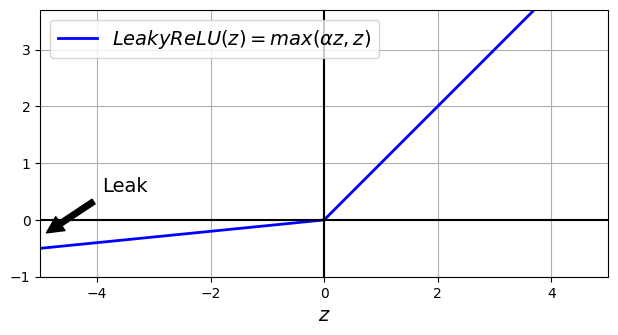

In [24]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

leaky ReLU를 사용하는 2가지 방법

In [25]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


- LeakyReLU를 activation 파라미터로 전달
    - alpha=0.2: 음수 입력에 대해 0.2를 곱함

In [26]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

- 활성화 함수를 별도 레이어로 분리
    - 활성화 함수 없이 dense layer만 생성 
    - LeakyReLU(alpha=0.2): 별도의 레이어로 추가

### ELU

- ReLU의 변형으로 음수 영역에서도 부드러운 기울기를 제공(미분 가능)
- z ≥ 0: ELU(z) = z
- z < 0: ELU(z) = α(e^z - 1)

In [27]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

ELU의 스케일된 버전으로 self-normalizing 특성을 가짐.
- SELU(z) = scale × ELU(z, alpha)
- 기본적으로 SELU의 하이퍼파라미터(scale, alpha)는 각 뉴런의 평균출력이 0에 가깝고 표준편차가 1에 가깝도록 조정됨. 이 활성화함수를 사용하면 1,000층 깊이의 신경망에서도 모든 층에 걸쳐 대략 평균 0과 표준 편차 1을 유지하여 기울기 vanishing/ exploding 문제를 피할 수 있음
- 자기 정규화: 각 층의 출력이 자동으로 평균 0, 표준편차 1에 가깝게 유지됨

In [28]:
from scipy.special import erfc

# alpha와 scale을 자기 정규화하도록 계산 (평균 0, 표준편차 1)
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi + 2
    ) ** (-1 / 2)
)

In [29]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

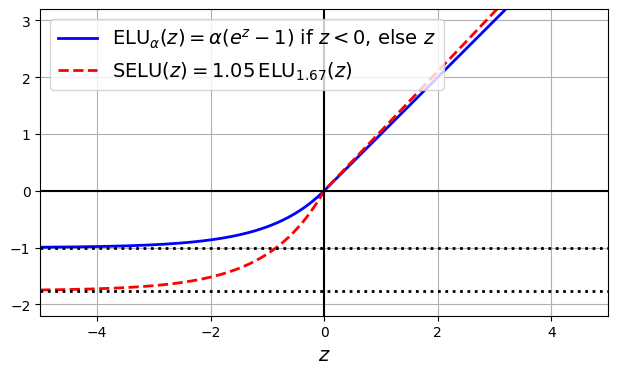

In [30]:
z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

In [3]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**Extra material – an example of a self-regularized network using SELU**

fashion MINST를 가지고 100층짜리 deep network를 SELU를 이용해 학습

In [25]:
tf.random.set_seed(42)
model = tf.keras.Sequential()

# 입력 flatten
model.add(tf.keras.layers.Flatten(input_shape=[28, 28])) # MNIST는 28*28이미지. dense층은 벡터입력만 받으므로 flatten은 (28,28)을 784차원 벡터로 펼침.

# 100개의 dense layer + SELU + LeCun Normal
for layer in range(100):
    model.add(tf.keras.layers.Dense(
        100, activation="selu", 
        kernel_initializer="lecun_normal"
    ))

# 출력 레이어: fasion MNIST는 10개의 클래스, 배운 것 처럼 softmax는 확률 분포를 만들기 때문에 멀티클래스 분류에 사용
model.add(tf.keras.layers.Dense(10, activation="softmax"))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"]
)

loss = "sparse_categorical_crossentropy"
- y가 원-핫이 아니라 숫자형 label(0~9)일때 쓰는 손실함수


optimizer는 일반적인 SGD(lr=0.001) 사용 <br/>
100층이기 때문에 lr을 낮게 설정

In [27]:
# 이제 훈련 시작
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist # train/test 분리

In [28]:
# validation 분리 
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

- train: 55,000개
- valid: 5,000개
- test: 10,000개


In [29]:
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

- 인풋 scaling 우선 : mean = 0, std = 1로 **정규화**
    - SELU는 **입력의 평균이 0이고 표준편차가 1일때 가장 안정적으로 동작**
    - 원본 이미지 픽셀 값은 0 ~ 255, 평균도 크고 분산도 큼

In [30]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [31]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

- 표준화를 추가로 진행
    - 위에서 scaling 한 것은 정규화한 것

In [32]:
history_selu = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.5935 - loss: 1.0919 - val_accuracy: 0.7096 - val_loss: 0.7798
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6715 - loss: 0.8987 - val_accuracy: 0.6998 - val_loss: 0.7989
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7363 - loss: 0.7245 - val_accuracy: 0.7624 - val_loss: 0.6738
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7530 - loss: 0.6924 - val_accuracy: 0.7708 - val_loss: 0.6602
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7923 - loss: 0.5963 - val_accuracy: 0.8082 - val_loss: 0.5419


In [ ]:
# SELU와 동일한 네트워크를 ReLU로 바꿔서 학습 
# -> 성능/학습 안전성 사이를 비교하기 위해

tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(
        100, activation="relu", 
        kernel_initializer="lecun_normal"
    ))
model.add(tf.keras.layers.Dense(10, activation="softmax"))


In [34]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"]
)

In [35]:
history_relu = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.0991 - loss: 2.3026 - val_accuracy: 0.0900 - val_loss: 2.3026
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.0994 - loss: 2.3026 - val_accuracy: 0.0900 - val_loss: 2.3027
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.1002 - loss: 2.3026 - val_accuracy: 0.0900 - val_loss: 2.3027
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.1008 - loss: 2.3026 - val_accuracy: 0.0900 - val_loss: 2.3027
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1008 - loss: 2.3026 - val_accuracy: 0.0900 - val_loss: 2.3027


위에서 결과를 비교해보면 
- SELU는 accuracy가 0.58로 시작해서 손실값은 계속 감소하고 0.8까지 증가한 것을 확인할 수 있음
- 다만, ReLU의 accuracy는 0.1에서 고정됨을 확인할 수 있음 
    - Why? 
        - 가중치 초기화 + 깊은 네트워크 -> gradient가 0이 되기 쉬운 구조
        - 학습이 진행되지 않으면 loss과 accuracy 값이 고정됨

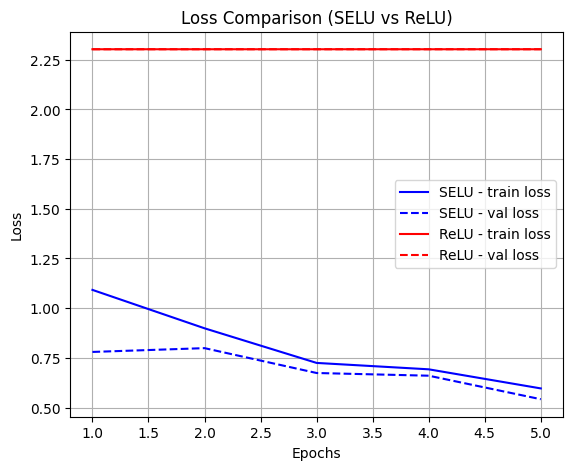

In [36]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_selu.history["loss"]) + 1)

plt.figure(figsize=(14, 5))

# loss comparison
plt.subplot(1, 2, 1)
plt.plot(epochs, history_selu.history["loss"], "b-", label="SELU - train loss")
plt.plot(epochs, history_selu.history["val_loss"], "b--", label="SELU - val loss")
plt.plot(epochs, history_relu.history["loss"], "r-", label="ReLU - train loss")
plt.plot(epochs, history_relu.history["val_loss"], "r--", label="ReLU - val loss")
plt.title("Loss Comparison (SELU vs ReLU)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

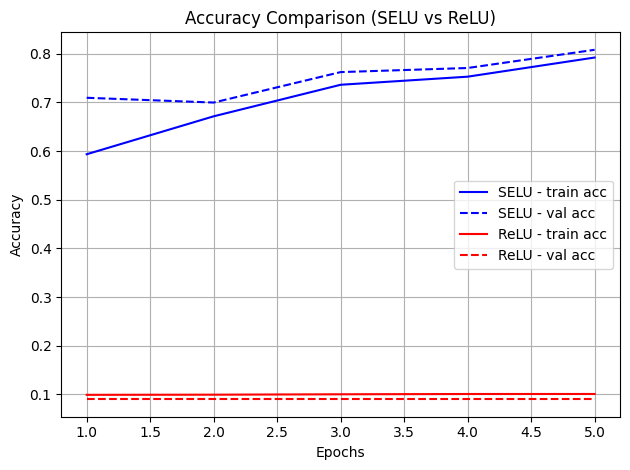

In [37]:
# accuracy comparison
plt.plot(epochs, history_selu.history["accuracy"], "b-", label="SELU - train acc")
plt.plot(epochs, history_selu.history["val_accuracy"], "b--", label="SELU - val acc")
plt.plot(epochs, history_relu.history["accuracy"], "r-", label="ReLU - train acc")
plt.plot(epochs, history_relu.history["val_accuracy"], "r--", label="ReLU - val acc")
plt.title("Accuracy Comparison (SELU vs ReLU)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Faster Optimizers

In [40]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        # hidden layer 3개, 각 100개 neurons, activation function은 ReLU
        tf.keras.layers.Dense(100, activation="relu", 
                                kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", 
                                kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", 
                                kernel_initializer="he_normal"),
        # output layer: 10개의 클래스, softmax는 확률 분포를 만들기 때문에 멀티클래스 분류에 사용
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    
def build_and_train_model(optimizer):
    """
    모델을 생성하고 컴파일 한 뒤 학습까지 수행하는 파이프라인 메소드
    """
    model = build_model()
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    return model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

In [39]:
# 일단 기본 SGD로 optimization
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

In [41]:
history_sgd = build_and_train_model(optimizer)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5626 - loss: 1.4420 - val_accuracy: 0.7288 - val_loss: 0.8822
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - accuracy: 0.7419 - loss: 0.7823 - val_accuracy: 0.7690 - val_loss: 0.6934
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 965us/step - accuracy: 0.7747 - loss: 0.6683 - val_accuracy: 0.7896 - val_loss: 0.6210
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7924 - loss: 0.6098 - val_accuracy: 0.7988 - val_loss: 0.5772
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8052 - loss: 0.5715 - val_accuracy: 0.8086 - val_loss: 0.5473
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8142 - loss: 0.5440 - val_accuracy: 0.8174 - val_loss: 0.5251
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 938us/step - accuracy: 0.8207 - loss: 0.5232 - val_accuracy: 0.8224 - val_loss: 0.5082
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step - accuracy: 0.8257 - loss: 0

- sgd 말고 다른 faster optimizer를 알아볼것임. 
- 기본 sgd보다 더 빠르게 수렴하는 optimizer 비교

## Momentum optimization

- 과거 gradient의 이동 평균(관성)을 활용
    - m = β * m + ∇θ (β는 momentum, 보통 0.9)
    - θ = θ - lr * m

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [43]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7576 - loss: 0.7054 - val_accuracy: 0.8192 - val_loss: 0.5033
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8369 - loss: 0.4664 - val_accuracy: 0.8358 - val_loss: 0.4536
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8521 - loss: 0.4209 - val_accuracy: 0.8428 - val_loss: 0.4261
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8606 - loss: 0.3937 - val_accuracy: 0.8500 - val_loss: 0.4042
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8671 - loss: 0.3744 - val_accuracy: 0.8540 - val_loss: 0.3925
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8724 - loss: 0.3585 - val_accuracy: 0.8590 - val_loss: 0.3811
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8763 - loss: 0.3453 - val_accuracy: 0.8608 - val_loss: 0.3747
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8798 - loss: 0.3344 - 

## Nesterov Accelerated Gradient

- momentum의 개선 버전. 미리 예측한 위치에서 gradient 계산
    - θ_lookahead = θ + β * m
    - m = β * m + ∇θ_lookahead
    - θ = θ - lr * m

In [44]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [45]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7702 - loss: 0.6752 - val_accuracy: 0.8228 - val_loss: 0.4912
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8387 - loss: 0.4566 - val_accuracy: 0.8390 - val_loss: 0.4484
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8528 - loss: 0.4150 - val_accuracy: 0.8482 - val_loss: 0.4203
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8619 - loss: 0.3880 - val_accuracy: 0.8528 - val_loss: 0.4065
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8686 - loss: 0.3684 - val_accuracy: 0.8538 - val_loss: 0.3980
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8732 - loss: 0.3525 - val_accuracy: 0.8580 - val_loss: 0.3863
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8776 - loss: 0.3390 - val_accuracy: 0.8600 - val_loss: 0.3787
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8818 - loss: 0.3278 - 

## AdaGrad

- 파라미터별로 학습률을 적응적으로 조정
    - 자주 업데이트되는 파라미터는 작은 학습률
    - s = s + (∇θ)² 
    - θ = θ - lr * ∇θ / (√s + ε)

In [46]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [47]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6900 - loss: 0.9891 - val_accuracy: 0.7748 - val_loss: 0.6894
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7861 - loss: 0.6420 - val_accuracy: 0.7992 - val_loss: 0.5888
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8064 - loss: 0.5730 - val_accuracy: 0.8142 - val_loss: 0.5454
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8178 - loss: 0.5371 - val_accuracy: 0.8214 - val_loss: 0.5192
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8250 - loss: 0.5137 - val_accuracy: 0.8260 - val_loss: 0.5011
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8309 - loss: 0.4967 - val_accuracy: 0.8282 - val_loss: 0.4876
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8349 - loss: 0.4837 - val_accuracy: 0.8318 - val_loss: 0.4769
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8384 - loss: 0.4731 - 

## RMSProp

- Root Mean Square Propagation
- AdaGrad의 개선. 최근 gradient에 더 큰 가중치를 주도록 조정 
    - s = ρ * s + (1-ρ) * (∇θ)²
    - θ = θ - lr * ∇θ / (√s + ε)

In [48]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [49]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8126 - loss: 0.5159 - val_accuracy: 0.8322 - val_loss: 0.4436
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8597 - loss: 0.3920 - val_accuracy: 0.8620 - val_loss: 0.3911
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8704 - loss: 0.3645 - val_accuracy: 0.8512 - val_loss: 0.4365
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8766 - loss: 0.3502 - val_accuracy: 0.8530 - val_loss: 0.4482
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8811 - loss: 0.3455 - val_accuracy: 0.8592 - val_loss: 0.4740
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8826 - loss: 0.3415 - val_accuracy: 0.8560 - val_loss: 0.4941
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8828 - loss: 0.3392 - val_accuracy: 0.8672 - val_loss: 0.4844
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8825 - loss: 0.3394 - 

## Adam Optimization

- Momentum과 RMSProp를 결합
    - m = β₁ * m + (1-β₁) * ∇θ (1차 모멘트)
    - v = β₂ * v + (1-β₂) * (∇θ)² (2차 모멘트)
    - m̂ = m / (1-β₁ᵗ), v̂ = v / (1-β₂ᵗ) (bias correction)
    - θ = θ - lr * m̂ / (√v̂ + ε)

In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [51]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8198 - loss: 0.5040 - val_accuracy: 0.8274 - val_loss: 0.4300
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8615 - loss: 0.3771 - val_accuracy: 0.8350 - val_loss: 0.4180
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8753 - loss: 0.3393 - val_accuracy: 0.8478 - val_loss: 0.3901
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8826 - loss: 0.3152 - val_accuracy: 0.8616 - val_loss: 0.3625
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8892 - loss: 0.2983 - val_accuracy: 0.8674 - val_loss: 0.3588
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8947 - loss: 0.2809 - val_accuracy: 0.8730 - val_loss: 0.3560
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.2684 - val_accuracy: 0.8752 - val_loss: 0.3515
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9021 - loss: 0.2590 - 

## Adamax Optimization

- adam의 변형. inf norm 사용
    - m = β₁ * m + (1-β₁) * ∇θ
    - u = max(β₂ * u, |∇θ|) (최대값 추적)
    - θ = θ - lr * m / u

In [52]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [53]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8132 - loss: 0.5373 - val_accuracy: 0.8368 - val_loss: 0.4432
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8587 - loss: 0.3974 - val_accuracy: 0.8480 - val_loss: 0.4039
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8723 - loss: 0.3576 - val_accuracy: 0.8514 - val_loss: 0.3864
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8811 - loss: 0.3320 - val_accuracy: 0.8562 - val_loss: 0.3791
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8872 - loss: 0.3129 - val_accuracy: 0.8662 - val_loss: 0.3605
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8917 - loss: 0.2976 - val_accuracy: 0.8704 - val_loss: 0.3478
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8967 - loss: 0.2845 - val_accuracy: 0.8744 - val_loss: 0.3422
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9003 - loss: 0.2736 - 

## Nadam Optimization

- Adam + Nesterov
    - Adam의 momentum 부분에 Nesterov 적용

In [54]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [55]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8275 - loss: 0.4792 - val_accuracy: 0.8472 - val_loss: 0.3940
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8653 - loss: 0.3652 - val_accuracy: 0.8540 - val_loss: 0.3882
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8780 - loss: 0.3289 - val_accuracy: 0.8560 - val_loss: 0.3873
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8858 - loss: 0.3071 - val_accuracy: 0.8548 - val_loss: 0.3994
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8934 - loss: 0.2876 - val_accuracy: 0.8668 - val_loss: 0.3730
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8982 - loss: 0.2736 - val_accuracy: 0.8686 - val_loss: 0.3693
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9032 - loss: 0.2595 - val_accuracy: 0.8702 - val_loss: 0.3725
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9073 - loss: 0.2479 - 

## AdamW Optimization

- Adam with Weight Decay
    - Adam + weight decay를 적용 

In [56]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                      beta_1=0.9, beta_2=0.999)

In [57]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8222 - loss: 0.4914 - val_accuracy: 0.8296 - val_loss: 0.4350
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8631 - loss: 0.3746 - val_accuracy: 0.8524 - val_loss: 0.3917
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8758 - loss: 0.3381 - val_accuracy: 0.8606 - val_loss: 0.3724
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8850 - loss: 0.3119 - val_accuracy: 0.8656 - val_loss: 0.3649
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8914 - loss: 0.2936 - val_accuracy: 0.8708 - val_loss: 0.3611
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8966 - loss: 0.2796 - val_accuracy: 0.8694 - val_loss: 0.3715
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9012 - loss: 0.2655 - val_accuracy: 0.8752 - val_loss: 0.3595
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9042 - loss: 0.2556 - 

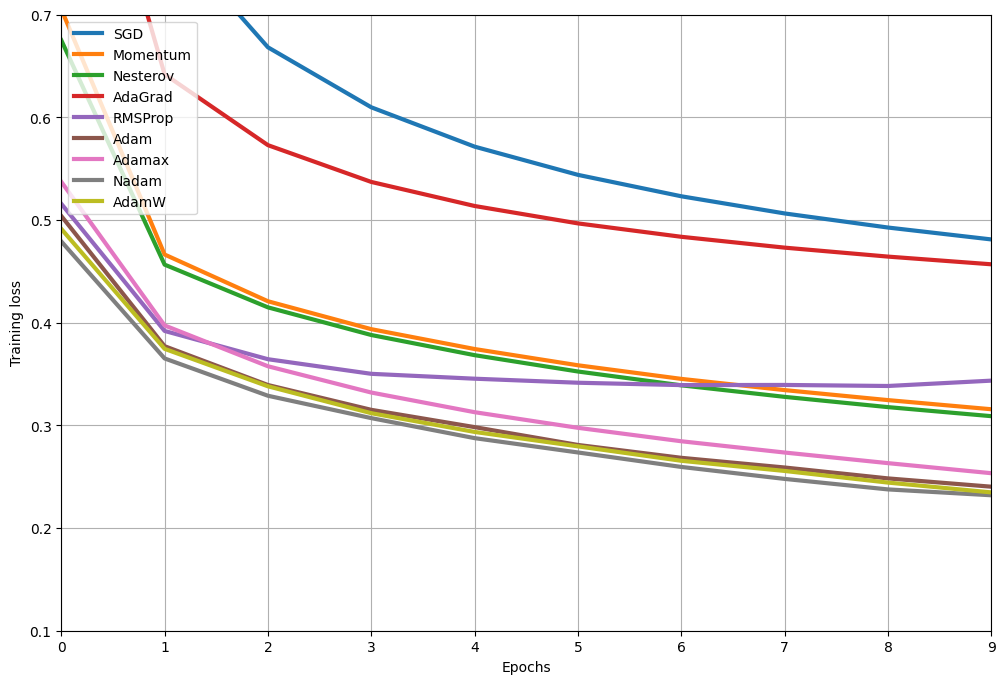

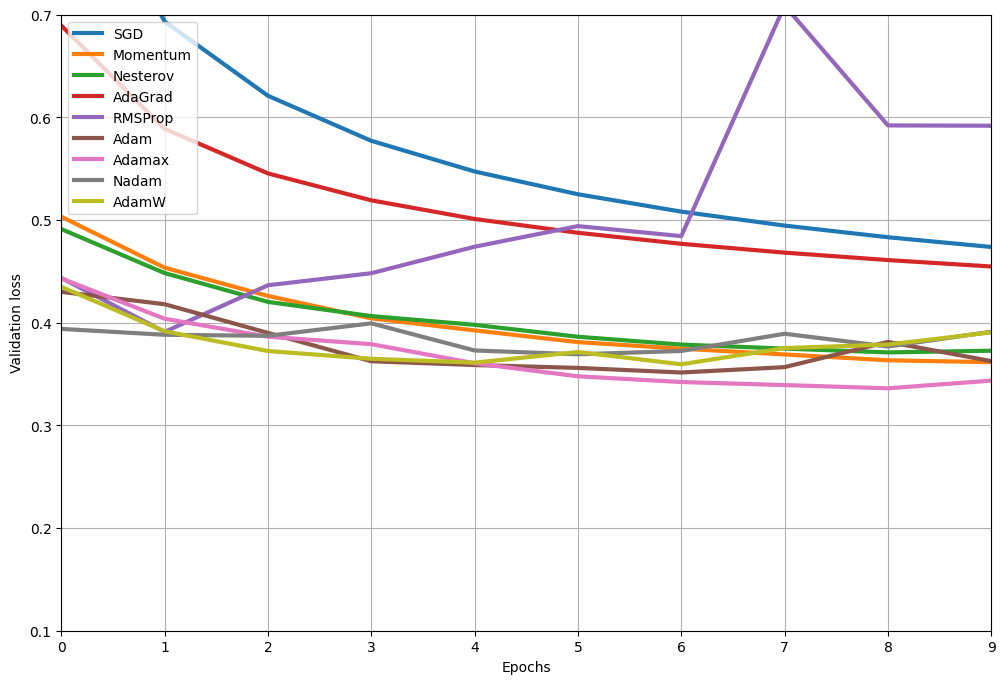

In [58]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()